# Use sklearn Gaussian Naive Bayes with a real student dataset

Kaggle dataset: https://www.kaggle.com/datasets/uciml/student-alcohol-consumption

In [2]:
%load_ext jupyter_black

In [9]:
import polars as pl
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

### Read the test dataset

In [10]:
df = pl.read_csv("../data/student_mat.csv")
df

school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,dalc,walc,health,absences,g1,g2,g3
str,str,i64,str,str,str,i64,i64,str,str,str,str,i64,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GP""","""F""",18,"""U""","""GT3""","""A""",4,4,"""at_home""","""teacher""","""course""","""mother""",2,2,0,true,false,false,false,true,true,false,false,4,3,4,1,1,3,6,5,6,6
"""GP""","""F""",17,"""U""","""GT3""","""T""",1,1,"""at_home""","""other""","""course""","""father""",1,2,0,false,true,false,false,false,true,true,false,5,3,3,1,1,3,4,5,5,6
"""GP""","""F""",15,"""U""","""LE3""","""T""",1,1,"""at_home""","""other""","""other""","""mother""",1,2,3,true,false,true,false,true,true,true,false,4,3,2,2,3,3,10,7,8,10
"""GP""","""F""",15,"""U""","""GT3""","""T""",4,2,"""health""","""services""","""home""","""mother""",1,3,0,false,true,true,true,true,true,true,true,3,2,2,1,1,5,2,15,14,15
"""GP""","""F""",16,"""U""","""GT3""","""T""",3,3,"""other""","""other""","""home""","""father""",1,2,0,false,true,true,false,true,true,false,false,4,3,2,1,2,5,4,6,10,10
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MS""","""M""",20,"""U""","""LE3""","""A""",2,2,"""services""","""services""","""course""","""other""",1,2,2,false,true,true,false,true,true,false,false,5,5,4,4,5,4,11,9,9,9
"""MS""","""M""",17,"""U""","""LE3""","""T""",3,1,"""services""","""services""","""course""","""mother""",2,1,0,false,false,false,false,false,true,true,false,2,4,5,3,4,2,3,14,16,16
"""MS""","""M""",21,"""R""","""GT3""","""T""",1,1,"""other""","""other""","""course""","""other""",1,1,3,false,false,false,false,false,true,false,false,5,5,3,3,3,3,3,10,8,7


### Rename some columns to make them more readable

In [11]:
df_2 = df.rename(
    {
        "sex": "gender",
        "famsize": "family_size",
        "pstatus": "parent_cohabit",
        "medu": "mother_education",
        "fedu": "father_education",
        "mjob": "mother_job",
        "fjob": "father_job",
        "traveltime": "travel_time",
        "studytime": "study_time",
        "failures": "num_failures",
        "schoolsup": "extra_school_support",
        "famsup": "family_support",
        "paid": "extra_paid_classes",
        "activities": "extra_curricular_activities",
        "nursery": "attended_nursery_school",
        "higher": "wants_higher_education",
        "internet": "has_internet",
        "romantic": "in_romantic_rel",
        "famrel": "family_rel_quality",
        "freetime": "free_time_amount",
        "goout": "goes_out_frequency",
        "dalc": "weekday_alcohol_consumption_amount",
        "walc": "weekend_alcohol_consumption_amount",
        "health": "quality_of_health",
        "absences": "absence_count",
    }
)
df_2 = df_2.filter(pl.col("g3") > 0)
df_2

school,gender,age,address,family_size,parent_cohabit,mother_education,father_education,mother_job,father_job,reason,guardian,travel_time,study_time,num_failures,extra_school_support,family_support,extra_paid_classes,extra_curricular_activities,attended_nursery_school,wants_higher_education,has_internet,in_romantic_rel,family_rel_quality,free_time_amount,goes_out_frequency,weekday_alcohol_consumption_amount,weekend_alcohol_consumption_amount,quality_of_health,absence_count,g1,g2,g3
str,str,i64,str,str,str,i64,i64,str,str,str,str,i64,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GP""","""F""",18,"""U""","""GT3""","""A""",4,4,"""at_home""","""teacher""","""course""","""mother""",2,2,0,true,false,false,false,true,true,false,false,4,3,4,1,1,3,6,5,6,6
"""GP""","""F""",17,"""U""","""GT3""","""T""",1,1,"""at_home""","""other""","""course""","""father""",1,2,0,false,true,false,false,false,true,true,false,5,3,3,1,1,3,4,5,5,6
"""GP""","""F""",15,"""U""","""LE3""","""T""",1,1,"""at_home""","""other""","""other""","""mother""",1,2,3,true,false,true,false,true,true,true,false,4,3,2,2,3,3,10,7,8,10
"""GP""","""F""",15,"""U""","""GT3""","""T""",4,2,"""health""","""services""","""home""","""mother""",1,3,0,false,true,true,true,true,true,true,true,3,2,2,1,1,5,2,15,14,15
"""GP""","""F""",16,"""U""","""GT3""","""T""",3,3,"""other""","""other""","""home""","""father""",1,2,0,false,true,true,false,true,true,false,false,4,3,2,1,2,5,4,6,10,10
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MS""","""M""",20,"""U""","""LE3""","""A""",2,2,"""services""","""services""","""course""","""other""",1,2,2,false,true,true,false,true,true,false,false,5,5,4,4,5,4,11,9,9,9
"""MS""","""M""",17,"""U""","""LE3""","""T""",3,1,"""services""","""services""","""course""","""mother""",2,1,0,false,false,false,false,false,true,true,false,2,4,5,3,4,2,3,14,16,16
"""MS""","""M""",21,"""R""","""GT3""","""T""",1,1,"""other""","""other""","""course""","""other""",1,1,3,false,false,false,false,false,true,false,false,5,5,3,3,3,3,3,10,8,7


### Clean up the data a little

In [12]:
# Use a LabelEncoder
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = LabelEncoder()

# List of columns that need to be assigned numeric values
columns_to_encode = [
    "school",
    "gender",
    "address",
    "family_size",
    "parent_cohabit",
    "mother_job",
    "father_job",
    "reason",
    "guardian",
]

# Convert values in the columns that should be encoded into encoded values
pl_series = [
    pl.Series(feature + "_num", le.fit_transform(df_2[feature]))
    for feature in columns_to_encode
]

# Create a new dataframe with the encoded data and the sample data
df_3 = df_2.with_columns(pl_series)

# Try categorizing absences into a new column
df_3 = df_3.with_columns(
    pl.when(pl.col("absence_count") <= 5)
    .then(0)
    .when((pl.col("absence_count") > 5) & (pl.col("absence_count") <= 10))
    .then(1)
    .when((pl.col("absence_count") > 10) & (pl.col("absence_count") <= 15))
    .then(2)
    .when((pl.col("absence_count") > 15) & (pl.col("absence_count") <= 20))
    .then(3)
    .otherwise(4)
    .cast(pl.Int64)
    .alias("absence_category"),
)
df_3

school,gender,age,address,family_size,parent_cohabit,mother_education,father_education,mother_job,father_job,reason,guardian,travel_time,study_time,num_failures,extra_school_support,family_support,extra_paid_classes,extra_curricular_activities,attended_nursery_school,wants_higher_education,has_internet,in_romantic_rel,family_rel_quality,free_time_amount,goes_out_frequency,weekday_alcohol_consumption_amount,weekend_alcohol_consumption_amount,quality_of_health,absence_count,g1,g2,g3,school_num,gender_num,address_num,family_size_num,parent_cohabit_num,mother_job_num,father_job_num,reason_num,guardian_num,absence_category
str,str,i64,str,str,str,i64,i64,str,str,str,str,i64,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GP""","""F""",18,"""U""","""GT3""","""A""",4,4,"""at_home""","""teacher""","""course""","""mother""",2,2,0,true,false,false,false,true,true,false,false,4,3,4,1,1,3,6,5,6,6,0,0,1,0,0,0,4,0,1,1
"""GP""","""F""",17,"""U""","""GT3""","""T""",1,1,"""at_home""","""other""","""course""","""father""",1,2,0,false,true,false,false,false,true,true,false,5,3,3,1,1,3,4,5,5,6,0,0,1,0,1,0,2,0,0,0
"""GP""","""F""",15,"""U""","""LE3""","""T""",1,1,"""at_home""","""other""","""other""","""mother""",1,2,3,true,false,true,false,true,true,true,false,4,3,2,2,3,3,10,7,8,10,0,0,1,1,1,0,2,2,1,1
"""GP""","""F""",15,"""U""","""GT3""","""T""",4,2,"""health""","""services""","""home""","""mother""",1,3,0,false,true,true,true,true,true,true,true,3,2,2,1,1,5,2,15,14,15,0,0,1,0,1,1,3,1,1,0
"""GP""","""F""",16,"""U""","""GT3""","""T""",3,3,"""other""","""other""","""home""","""father""",1,2,0,false,true,true,false,true,true,false,false,4,3,2,1,2,5,4,6,10,10,0,0,1,0,1,2,2,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MS""","""M""",20,"""U""","""LE3""","""A""",2,2,"""services""","""services""","""course""","""other""",1,2,2,false,true,true,false,true,true,false,false,5,5,4,4,5,4,11,9,9,9,1,1,1,1,0,3,3,0,2,2
"""MS""","""M""",17,"""U""","""LE3""","""T""",3,1,"""services""","""services""","""course""","""mother""",2,1,0,false,false,false,false,false,true,true,false,2,4,5,3,4,2,3,14,16,16,1,1,1,1,1,3,3,0,1,0
"""MS""","""M""",21,"""R""","""GT3""","""T""",1,1,"""other""","""other""","""course""","""other""",1,1,3,false,false,false,false,false,true,false,false,5,5,3,3,3,3,3,10,8,7,1,1,0,0,1,2,2,0,2,0


### Create a function to do the training and test and return the accuracy so i don't need to copy and paste over and over

In [16]:
def fit_and_test(
    df: pl.DataFrame,
    columns_to_drop: list[str],
    category_column: str,
    log: bool = False,
    return_gnb: bool = False,
    count: int = 100,
) -> float:
    # Extract features and labels
    X = df.drop(columns_to_drop)
    y = df[category_column]
    accuracy_seen = []

    for i in range(count):
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=0.9,
            random_state=42,  # train_size=0.999
        )

        # Initialize the Gaussian Naive Bayes classifier
        gnb = GaussianNB()

        # Train the model
        gnb.fit(X_train, y_train)

        # Predict the labels for the test set
        y_pred = gnb.predict(X_test)
        if log:
            print(f"Predicted values: {y_pred}")

        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # print(f"Accuracy: {accuracy}")
        accuracy_seen.append(accuracy)

        if i == count - 1:
            # Optionally, visualize the results
            plt.figure(figsize=(8, 5))
            plt.scatter(y_test, y_pred, color="blue", label="Predicted values")
            plt.plot(
                [min(y_test), max(y_test)],
                [min(y_test), max(y_test)],
                color="red",
                linestyle="--",
            )  # Ideal line

            plt.xlabel("Scaled Feature")
            plt.ylabel("Target")
            plt.title("Linear Regression: Actual vs Predicted on Scaled Data")
            plt.legend()
            plt.show()

    average_accuracy = sum(accuracy_seen) / count
    if log:
        print(f"average accuracy: {average_accuracy}")

    if return_gnb:
        return (average_accuracy, gnb)
    else:
        return average_accuracy

### Check the accuracy when using all data

will drop: school
will drop: gender
will drop: address
will drop: family_size
will drop: parent_cohabit
will drop: mother_job
will drop: father_job
will drop: reason
will drop: guardian


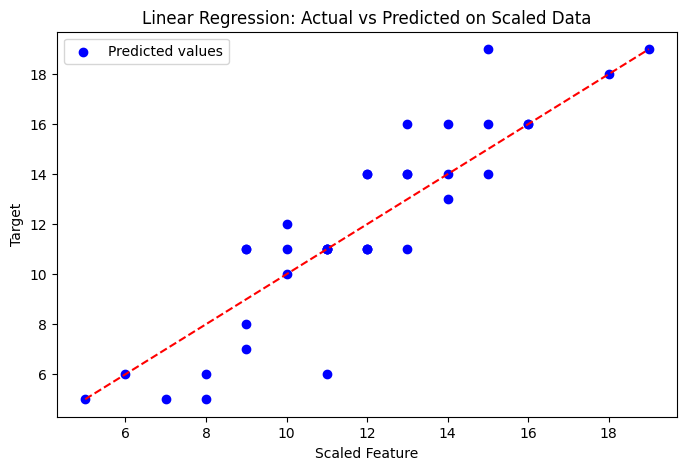

0.33333333333333326

In [17]:
columns_to_keep = set()

df_3.schema.to_python()
for k, v in df_3.schema.to_python().items():
    if v != str:
        columns_to_keep.add(k)
    else:
        print(f"will drop: {k}")
columns_to_drop = (set(df_3.columns) - columns_to_keep) | {"g3"}

fit_and_test(df_3, columns_to_drop, "g3")

### I picked some columns i liked to see how good they are
This isn't as good as using the entire dataset

In [24]:
columns_to_keep = {
    "weekday_alcohol_consumption_amount",
    "weekend_alcohol_consumption_amount",
    "quality_of_health",
    "absence_count",
    "study_time",
    "extra_paid_classes_num",
    "extra_school_support_num",
    "has_internet_num",
}

columns_to_drop = set(df_3.columns) - columns_to_keep

fit_and_test(df_3, columns_to_drop, "g3")

0.1061111111111111

### I tried adding a few more
This still isn't as good as using the entire dataset

In [25]:
columns_to_keep = {
    "weekday_alcohol_consumption_amount",
    "weekend_alcohol_consumption_amount",
    "quality_of_health",
    "absence_count",
    "study_time",
    "extra_paid_classes_num",
    "extra_school_support_num",
    "family_support_num",
    "has_internet_num",
    "father_job_num",
    "mother_job_num",
}

columns_to_drop = set(df_3.columns) - columns_to_keep

fit_and_test(df_3, columns_to_drop, "g3")

0.10388888888888888

### Try each column one at a time to see which are best

In [26]:
p1 = {
    "category": [],
    "accuracy": [],
}

all_columns = set(df_3.columns)
df_3.schema.to_python()
for k, v in df_3.schema.to_python().items():
    columns_to_keep = set()
    if v != str and k not in {
        # "g1",
        # "g2",
        "g3",
    }:
        columns_to_keep.add(k)
        columns_to_drop = all_columns - columns_to_keep
        accuracy = fit_and_test(df_3, columns_to_drop, "g3")
        p1["category"].append(k)
        p1["accuracy"].append(accuracy)

df_accuracy = (
    pl.DataFrame(
        p1,
        schema={
            "category": pl.String,
            "accuracy": pl.Float64,
        },
    )
    .sort("accuracy")
    .top_k(20, by="accuracy")
)
with pl.Config(tbl_rows=2000):
    print(df_accuracy)

shape: (20, 2)
┌─────────────────────────────────┬──────────┐
│ category                        ┆ accuracy │
│ ---                             ┆ ---      │
│ str                             ┆ f64      │
╞═════════════════════════════════╪══════════╡
│ g2                              ┆ 0.493889 │
│ g1                              ┆ 0.255    │
│ father_education                ┆ 0.140556 │
│ wants_higher_education          ┆ 0.135556 │
│ quality_of_health               ┆ 0.132778 │
│ mother_education                ┆ 0.122222 │
│ absence_count                   ┆ 0.118333 │
│ weekend_alcohol_consumption_am… ┆ 0.111667 │
│ free_time_amount                ┆ 0.096667 │
│ goes_out_frequency              ┆ 0.092778 │
│ mother_job_num                  ┆ 0.085556 │
│ reason_num                      ┆ 0.083889 │
│ study_time                      ┆ 0.082222 │
│ travel_time                     ┆ 0.072778 │
│ guardian_num                    ┆ 0.072778 │
│ has_internet                    ┆ 0.070556 

### Now try every combination of two columns

In [27]:
p1 = {
    "category1": [],
    "category2": [],
    "accuracy": [],
}

all_columns = set(df_3.columns)
name_type_pairs = [(k, v) for k, v in df_3.schema.to_python().items()]
for i in range(len(name_type_pairs) - 1):
    if name_type_pairs[i][1] != str and name_type_pairs[i][0] not in {
        # "g1",
        # "g2",
        "g3",
    }:
        for j in range(i + 1, len(name_type_pairs)):
            if name_type_pairs[j][1] != str and name_type_pairs[j][0] not in {
                # "g1",
                # "g2",
                "g3",
            }:
                columns_to_keep = {name_type_pairs[i][0], name_type_pairs[j][0]}
                columns_to_drop = all_columns - columns_to_keep
                accuracy = fit_and_test(df_3, columns_to_drop, "g3")
                p1["category1"].append(name_type_pairs[i][0])
                p1["category2"].append(name_type_pairs[j][0])
                p1["accuracy"].append(accuracy)

df_accuracy = (
    pl.DataFrame(
        p1,
        schema={
            "category1": pl.String,
            "category2": pl.String,
            "accuracy": pl.Float64,
        },
    )
    .sort("accuracy")
    .top_k(20, by="accuracy")
)
with pl.Config(tbl_rows=2000):
    print(df_accuracy)

shape: (20, 3)
┌─────────────────────────────────┬──────────────────┬──────────┐
│ category1                       ┆ category2        ┆ accuracy │
│ ---                             ┆ ---              ┆ ---      │
│ str                             ┆ str              ┆ f64      │
╞═════════════════════════════════╪══════════════════╪══════════╡
│ father_education                ┆ g2               ┆ 0.513889 │
│ g2                              ┆ reason_num       ┆ 0.498889 │
│ g2                              ┆ gender_num       ┆ 0.497222 │
│ goes_out_frequency              ┆ g2               ┆ 0.488333 │
│ free_time_amount                ┆ g2               ┆ 0.487778 │
│ g2                              ┆ father_job_num   ┆ 0.487222 │
│ mother_education                ┆ g2               ┆ 0.485556 │
│ g2                              ┆ absence_category ┆ 0.478333 │
│ study_time                      ┆ g2               ┆ 0.476667 │
│ extra_paid_classes              ┆ g2               ┆ 0.4733

### Now try every combination of three columns!

In [28]:
p1 = {
    "category1": [],
    "category2": [],
    "category3": [],
    "accuracy": [],
}

all_columns = set(df_3.columns)
name_type_pairs = [(k, v) for k, v in df_3.schema.to_python().items()]
for i in range(len(name_type_pairs) - 1):
    if name_type_pairs[i][1] != str and name_type_pairs[i][0] not in {
        # "g1",
        # "g2",
        "g3",
    }:
        for j in range(i + 1, len(name_type_pairs)):
            if name_type_pairs[j][1] != str and name_type_pairs[j][0] not in {
                # "g1",
                # "g2",
                "g3",
            }:
                for k in range(j + 1, len(name_type_pairs)):
                    if name_type_pairs[k][1] != str and name_type_pairs[k][0] not in {
                        # "g1",
                        # "g2",
                        "g3",
                    }:
                        columns_to_keep = {
                            name_type_pairs[i][0],
                            name_type_pairs[j][0],
                            name_type_pairs[k][0],
                        }
                        columns_to_drop = all_columns - columns_to_keep
                        accuracy = fit_and_test(
                            df_3,
                            columns_to_drop,
                            "g3",
                            count=10,
                        )
                        p1["category1"].append(name_type_pairs[i][0])
                        p1["category2"].append(name_type_pairs[j][0])
                        p1["category3"].append(name_type_pairs[k][0])
                        p1["accuracy"].append(accuracy)

df_accuracy = (
    pl.DataFrame(
        p1,
        schema={
            "category1": pl.String,
            "category2": pl.String,
            "category3": pl.String,
            "accuracy": pl.Float64,
        },
    )
    .sort("accuracy")
    .top_k(20, by="accuracy")
)
with pl.Config(tbl_rows=2000):
    print(df_accuracy)

shape: (20, 4)
┌─────────────────────────────────┬─────────────────────────────────┬──────────────────┬──────────┐
│ category1                       ┆ category2                       ┆ category3        ┆ accuracy │
│ ---                             ┆ ---                             ┆ ---              ┆ ---      │
│ str                             ┆ str                             ┆ str              ┆ f64      │
╞═════════════════════════════════╪═════════════════════════════════╪══════════════════╪══════════╡
│ father_education                ┆ g2                              ┆ reason_num       ┆ 0.594444 │
│ g2                              ┆ family_size_num                 ┆ absence_category ┆ 0.555556 │
│ mother_education                ┆ g2                              ┆ father_job_num   ┆ 0.55     │
│ age                             ┆ mother_education                ┆ g2               ┆ 0.544444 │
│ extra_curricular_activities     ┆ g2                              ┆ reason_num     

### Now try every combination of four columns!!

In [29]:
p1 = {
    "category1": [],
    "category2": [],
    "category3": [],
    "category4": [],
    "accuracy": [],
}

all_columns = set(df_3.columns)
name_type_pairs = [(k, v) for k, v in df_3.schema.to_python().items()]
for i in range(len(name_type_pairs) - 1):
    if name_type_pairs[i][1] != str and name_type_pairs[i][0] not in {
        # "g1",
        # "g2",
        "g3",
    }:
        for j in range(i + 1, len(name_type_pairs)):
            if name_type_pairs[j][1] != str and name_type_pairs[j][0] not in {
                # "g1",
                # "g2",
                "g3",
            }:
                for k in range(j + 1, len(name_type_pairs)):
                    if name_type_pairs[k][1] != str and name_type_pairs[k][0] not in {
                        # "g1",
                        # "g2",
                        "g3",
                    }:
                        for l in range(k + 1, len(name_type_pairs)):
                            if name_type_pairs[l][1] != str and name_type_pairs[l][
                                0
                            ] not in {
                                # "g1",
                                # "g2",
                                "g3",
                            }:
                                columns_to_keep = {
                                    name_type_pairs[i][0],
                                    name_type_pairs[j][0],
                                    name_type_pairs[k][0],
                                    name_type_pairs[l][0],
                                }
                                columns_to_drop = all_columns - columns_to_keep
                                accuracy = fit_and_test(
                                    df_3,
                                    columns_to_drop,
                                    "g3",
                                    count=10,
                                )
                                p1["category1"].append(name_type_pairs[i][0])
                                p1["category2"].append(name_type_pairs[j][0])
                                p1["category3"].append(name_type_pairs[k][0])
                                p1["category4"].append(name_type_pairs[l][0])
                                p1["accuracy"].append(accuracy)

df_accuracy = (
    pl.DataFrame(
        p1,
        schema={
            "category1": pl.String,
            "category2": pl.String,
            "category3": pl.String,
            "category4": pl.String,
            "accuracy": pl.Float64,
        },
    )
    .sort("accuracy")
    .top_k(20, by="accuracy")
)
with pl.Config(tbl_rows=2000):
    print(df_accuracy)

shape: (20, 5)
┌─────────────────────────────┬─────────────────────────────┬────────────────────────────┬──────────────────┬──────────┐
│ category1                   ┆ category2                   ┆ category3                  ┆ category4        ┆ accuracy │
│ ---                         ┆ ---                         ┆ ---                        ┆ ---              ┆ ---      │
│ str                         ┆ str                         ┆ str                        ┆ str              ┆ f64      │
╞═════════════════════════════╪═════════════════════════════╪════════════════════════════╪══════════════════╪══════════╡
│ g1                          ┆ g2                          ┆ father_job_num             ┆ reason_num       ┆ 0.555556 │
│ family_support              ┆ extra_curricular_activities ┆ g2                         ┆ gender_num       ┆ 0.555556 │
│ father_education            ┆ family_support              ┆ weekend_alcohol_consumptio ┆ g2               ┆ 0.55     │
│                

In [30]:
p1 = {
    "category1": [],
    "category2": [],
    "category3": [],
    "category4": [],
    "category5": [],
    "accuracy": [],
}

all_columns = set(df_3.columns)
name_type_pairs = [(k, v) for k, v in df_3.schema.to_python().items()]
for i in range(len(name_type_pairs) - 1):
    if name_type_pairs[i][1] != str and name_type_pairs[i][0] not in {
        # "g1",
        # "g2",
        "g3",
    }:
        for j in range(i + 1, len(name_type_pairs)):
            if name_type_pairs[j][1] != str and name_type_pairs[j][0] not in {
                # "g1",
                # "g2",
                "g3",
            }:
                for k in range(j + 1, len(name_type_pairs)):
                    if name_type_pairs[k][1] != str and name_type_pairs[k][0] not in {
                        # "g1",
                        # "g2",
                        "g3",
                    }:
                        for l in range(k + 1, len(name_type_pairs)):
                            if name_type_pairs[l][1] != str and name_type_pairs[l][
                                0
                            ] not in {
                                # "g1",
                                # "g2",
                                "g3",
                            }:
                                for m in range(l + 1, len(name_type_pairs)):
                                    if name_type_pairs[m][1] != str and name_type_pairs[
                                        m
                                    ][0] not in {
                                        # "g1",
                                        # "g2",
                                        "g3",
                                    }:
                                        columns_to_keep = {
                                            name_type_pairs[i][0],
                                            name_type_pairs[j][0],
                                            name_type_pairs[k][0],
                                            name_type_pairs[l][0],
                                            name_type_pairs[m][0],
                                        }
                                        columns_to_drop = all_columns - columns_to_keep
                                        accuracy = fit_and_test(
                                            df_3, columns_to_drop, "g3", count=5
                                        )
                                        p1["category1"].append(name_type_pairs[i][0])
                                        p1["category2"].append(name_type_pairs[j][0])
                                        p1["category3"].append(name_type_pairs[k][0])
                                        p1["category4"].append(name_type_pairs[l][0])
                                        p1["category5"].append(name_type_pairs[m][0])
                                        p1["accuracy"].append(accuracy)

df_accuracy = (
    pl.DataFrame(
        p1,
        schema={
            "category1": pl.String,
            "category2": pl.String,
            "category3": pl.String,
            "category4": pl.String,
            "category5": pl.String,
            "accuracy": pl.Float64,
        },
    )
    .sort("accuracy")
    .top_k(20, by="accuracy")
)
with pl.Config(tbl_rows=2000):
    print(df_accuracy)

shape: (20, 6)
┌──────────────────────┬──────────────────────┬──────────────────────┬────────────────────┬─────────────────┬──────────┐
│ category1            ┆ category2            ┆ category3            ┆ category4          ┆ category5       ┆ accuracy │
│ ---                  ┆ ---                  ┆ ---                  ┆ ---                ┆ ---             ┆ ---      │
│ str                  ┆ str                  ┆ str                  ┆ str                ┆ str             ┆ f64      │
╞══════════════════════╪══════════════════════╪══════════════════════╪════════════════════╪═════════════════╪══════════╡
│ travel_time          ┆ extra_paid_classes   ┆ weekend_alcohol_cons ┆ quality_of_health  ┆ g2              ┆ 0.633333 │
│                      ┆                      ┆ umption_am…          ┆                    ┆                 ┆          │
│ extra_curricular_act ┆ in_romantic_rel      ┆ g2                   ┆ gender_num         ┆ reason_num      ┆ 0.611111 │
│ ivities        

In [31]:
p1 = {
    "category1": [],
    "category2": [],
    "category3": [],
    "category4": [],
    "category5": [],
    "category6": [],
    "accuracy": [],
}

all_columns = set(df_3.columns)
name_type_pairs = [(k, v) for k, v in df_3.schema.to_python().items()]
for i in range(len(name_type_pairs) - 1):
    if name_type_pairs[i][1] != str and name_type_pairs[i][0] not in {
        # "g1",
        # "g2",
        "g3",
    }:
        for j in range(i + 1, len(name_type_pairs)):
            if name_type_pairs[j][1] != str and name_type_pairs[j][0] not in {
                # "g1",
                # "g2",
                "g3",
            }:
                for k in range(j + 1, len(name_type_pairs)):
                    if name_type_pairs[k][1] != str and name_type_pairs[k][0] not in {
                        # "g1",
                        # "g2",
                        "g3",
                    }:
                        for l in range(k + 1, len(name_type_pairs)):
                            if name_type_pairs[l][1] != str and name_type_pairs[l][
                                0
                            ] not in {
                                # "g1",
                                # "g2",
                                "g3",
                            }:
                                for m in range(l + 1, len(name_type_pairs)):
                                    if name_type_pairs[m][1] != str and name_type_pairs[
                                        m
                                    ][0] not in {
                                        # "g1",
                                        # "g2",
                                        "g3",
                                    }:
                                        for n in range(m + 1, len(name_type_pairs)):
                                            if name_type_pairs[n][
                                                1
                                            ] != str and name_type_pairs[n][0] not in {
                                                # "g1",
                                                # "g2",
                                                "g3",
                                            }:
                                                columns_to_keep = {
                                                    name_type_pairs[i][0],
                                                    name_type_pairs[j][0],
                                                    name_type_pairs[k][0],
                                                    name_type_pairs[l][0],
                                                    name_type_pairs[m][0],
                                                    name_type_pairs[n][0],
                                                }
                                                columns_to_drop = (
                                                    all_columns - columns_to_keep
                                                )
                                                accuracy = fit_and_test(
                                                    df_3, columns_to_drop, "g3", count=5
                                                )
                                                p1["category1"].append(
                                                    name_type_pairs[i][0]
                                                )
                                                p1["category2"].append(
                                                    name_type_pairs[j][0]
                                                )
                                                p1["category3"].append(
                                                    name_type_pairs[k][0]
                                                )
                                                p1["category4"].append(
                                                    name_type_pairs[l][0]
                                                )
                                                p1["category5"].append(
                                                    name_type_pairs[m][0]
                                                )
                                                p1["category6"].append(
                                                    name_type_pairs[n][0]
                                                )
                                                p1["accuracy"].append(accuracy)

df_accuracy = (
    pl.DataFrame(
        p1,
        schema={
            "category1": pl.String,
            "category2": pl.String,
            "category3": pl.String,
            "category4": pl.String,
            "category5": pl.String,
            "category6": pl.String,
            "accuracy": pl.Float64,
        },
    )
    .sort("accuracy")
    .top_k(20, by="accuracy")
)
with pl.Config(tbl_rows=2000):
    print(df_accuracy)

shape: (20, 7)
┌─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬──────────┐
│ category1       ┆ category2       ┆ category3       ┆ category4       ┆ category5       ┆ category6       ┆ accuracy │
│ ---             ┆ ---             ┆ ---             ┆ ---             ┆ ---             ┆ ---             ┆ ---      │
│ str             ┆ str             ┆ str             ┆ str             ┆ str             ┆ str             ┆ f64      │
╞═════════════════╪═════════════════╪═════════════════╪═════════════════╪═════════════════╪═════════════════╪══════════╡
│ free_time_amoun ┆ goes_out_freque ┆ quality_of_heal ┆ g1              ┆ g2              ┆ reason_num      ┆ 0.644444 │
│ t               ┆ ncy             ┆ th              ┆                 ┆                 ┆                 ┆          │
│ extra_curricula ┆ weekend_alcohol ┆ g1              ┆ g2              ┆ father_job_num  ┆ absence_categor ┆ 0.644444 │
│ r_activities   